In [2]:
import sys
import preprocessing_RK
import normalization_RK
import os
import numpy as np
import pandas as pd
from scipy import stats, signal
import mne
#from bids import BIDSLayout
import mne_bids
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, auc, precision_recall_curve, \
                            plot_precision_recall_curve
import multiprocessing
from pybv import write_brainvision
import matplotlib.pyplot as plt

inpath = '/Users/richardkoehler/Documents/Neurology_Data/BIDS Berlin/sub-004/ses-20200730/ieeg/'
outpath = '/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/'
filename = 'sub-004_ses-20200730_task-RotaSelfpaceOFFRefSTNR1_run-16_ieeg'

#select file in bids format
raw = mne_bids.read.io.brainvision.read_raw_brainvision(inpath + filename + '.vhdr', preload=True)

if raw.info['sfreq'] > 4096:
    raw.resample(4096, npad='auto')
elif raw.info['sfreq'] < 4096:
    print('Warning: sfreq < 4096, please adjust preprocessing_RK.py !')

Extracting parameters from /Users/richardkoehler/Documents/Neurology_Data/BIDS Berlin/sub-004/ses-20200730/ieeg/sub-004_ses-20200730_task-RotaSelfpaceOFFRefSTNR1_run-16_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 2103145  =      0.000 ...   513.167 secs...


KeyboardInterrupt: 

In [2]:
#set channeltypes
chan_type_set = { 'ECOG_AT_SM_L_{:1}'.format(n) : 'ecog' for n in range(1, 7) }
chan_type_set.update({'LFP_BS_STN_R_{:1}'.format(n) : 'ecog' for n in range(1, 9) })
chan_type_set.update({'LFP_BS_STN_L_{:1}'.format(n) : 'ecog' for n in range(1, 9) })
chan_type_set.update({ 'AUX_3_1' : 'misc' })
raw.set_channel_types(mapping=chan_type_set)

In [3]:
#rereference and rename ECoG channels
ecog_list = ['ECOG_AT_SM_L_{:1}'.format(n) for n in range(1, 7)]
raw_ecog_reref = raw.copy().pick(ecog_list).set_eeg_reference(ref_channels='average', projection=False)
channel_renaming_dict = {name: name + 'r' for name in raw_ecog_reref.ch_names}
raw_ecog_reref.rename_channels(channel_renaming_dict)

#rereference LFP_STNL8 against LFP_STNL1 and rename
raw_lfp_reref = raw.copy().pick(['LFP_BS_STN_L_1', 'LFP_BS_STN_L_8']).set_eeg_reference(ref_channels=['LFP_BS_STN_L_1'], \
                                                                              projection=False)
channel_renaming_dict = {name: name + 'r' for name in raw_lfp_reref.ch_names}
raw_lfp_reref.rename_channels(channel_renaming_dict)

#add rereferenced ECoG channels to raw
raw.add_channels([raw_ecog_reref], force_update_info=False)

#add rereferenced LFP_STNL8 channel to raw
raw.add_channels([raw_lfp_reref.pick(['LFP_BS_STN_L_8r'])], force_update_info=False)

#rename rotation channel
raw.rename_channels({'AUX_3_1' : 'ROTA'})

#extract and reorder relevant channels, ROTA should be last !
relev_chans = ['ECOG_AT_SM_L_1r', 'ECOG_AT_SM_L_2r', 'ECOG_AT_SM_L_3r', 'ECOG_AT_SM_L_4r', 'ECOG_AT_SM_L_5r', \
                      'ECOG_AT_SM_L_6r', 'LFP_BS_STN_R_8', 'LFP_BS_STN_L_8r', 'ROTA']
raw.reorder_channels(['ECOG_AT_SM_L_1r', 'ECOG_AT_SM_L_2r', 'ECOG_AT_SM_L_3r', 'ECOG_AT_SM_L_4r', 'ECOG_AT_SM_L_5r', \
                      'ECOG_AT_SM_L_6r', 'LFP_BS_STN_R_8', 'LFP_BS_STN_L_8r', 'ROTA'])

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.
ECoG channel type selected for re-referencing
Applying a custom ECoG reference.


<RawBrainVision  |  sub-004_ses-20200730_task-RotaSelfpaceOFFRefSTNR1_run-16_ieeg.eeg, n_channels x n_times : 9 x 2103146 (513.2 sec), ~144.4 MB, data loaded>

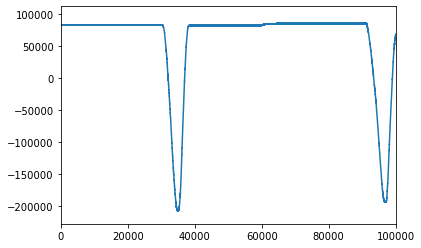

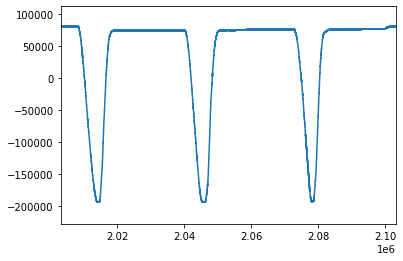

In [4]:
# Visual inspection for artefact cropping
data = raw.get_data()
#get tmin
plt.plot(data[-1,:])
plt.xlim(0,100000)
plt.show()
#get tmax
plt.plot(data[-1,:])
plt.xlim(len(data[-1,:])-100000,len(data[-1,:]))
plt.show()

In [5]:
#crop artefacts at end and beginning of recording after visual inspection
tmin = 50000
tmax = 2100000
tmax = tmax/raw.info['sfreq']
tmin = tmin/raw.info['sfreq']
crop_raw = raw.copy().crop(tmin=tmin, tmax=tmax, include_tmax=True)

#write data into brainvision file for further analyses
crop_data = crop_raw.get_data()
write_brainvision(crop_data, raw.info['sfreq'], relev_chans, 'crop_relevchan_' + filename, \
                  outpath, \
                  events=None, resolution=1e-07, unit='uV', scale_data=False, fmt='binary_float32', meas_date=None)

## Now copy and modify .tsv and .json files manually

In [ ]:
# Get recropped data, preprocess using modified script by TM
vhdr_file = outpath + 'crop_relevchan_reref_' + filename + '.vhdr'
xf_zs, ml_zs, xf_zs_r, ml_zs_r = preprocessing_RK.write_out_raw(vhdr_file, folder_out=outpath test_LM=False, \
                                                                resampling=True, write_json=False)

Extracting parameters from /Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/crop_relevchan_reref_sub-004_ses-20200730_task-RotaSelfpaceOFFRefSTNR1_run-16_ieeg.vhdr...
Setting channel info structure...


In [ ]:
# Create class labels using VPs normalization script (RK mod)
# Do baseline correction
mov = ml_zs_r[0,:].T*-1
mov_corrected, onoff, mov = normalization_RK.baseline_correction(mov, method='baseline_als', param=[1e3, 1e-4], \
                                                                 thr=1e-1, normalize=True, Decimate=10, Verbose=True)

# Create array of events
events_arr = normalization_RK.create_events_array(onoff, ml_zs[0,:], 1)
print('Number of detected events: ', len(events_arr[:,0])/2)

# Plot, evaluate, tweak param+thr in baseline_correction and rerun
fig, axs = plt.subplots(2, 2, figsize=(10,8), dpi=300)
axs[0, 0].plot(ml_zs_r[0,:])
axs[0, 0].set_title('ROTA')
axs[0, 1].plot(mov, 'tab:orange')
axs[0, 1].set_title('mov')
axs[1, 0].plot(mov_corrected, 'tab:green')
axs[1, 0].set_title('mov_corrected')
axs[1, 1].plot(onoff, 'tab:red')
axs[1, 1].set_title('onoff')
plt.show()

# Now plot and check accuracy
plt.figure(dpi=300, figsize=(7,5))
plt.title('Accuracy check')
plt.plot(events_arr[0:2,0], events_arr[0:2,1], 'r*')
plt.plot(ml_zs[0,:events_arr[2,0]]*2)
#plt.xlim(events_arr[0][0],events_arr[3][0])
plt.show()

In [ ]:
# Run LDA

print('Rolling Window = 1s, No Shuffle, Average all channels')

# Exclude border artefacts
art_ind = 3400
cor_ev = events_arr[:,0]-art_ind
X = xf_zs[:,:,art_ind:-art_ind]
print(X.shape)

# Now average over all channels
Xm = np.mean(X, axis=1)
Xm = Xm.T
print(Xm.shape)
    
# Add class labels from event array
y = np.zeros_like(X[0][0])
for i in np.arange(0,len(events_arr)-1,2):
    for s in np.arange(cor_ev[i], cor_ev[i+1]):
        y[s] = 1
    i=i+2

# Plot for plausability
plt.title('Plausability Check')
plt.plot(y)
plt.plot(ml_zs[0,art_ind:-art_ind])
plt.show()

#Split samples in test and train set
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(Xm, y, test_size=test_size, shuffle=False)

# Create LDA object
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# Train the model using the training sets
lda.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lda.predict(X_test)
y_pred_all = lda.predict(Xm)
   
# The coefficients
print('Coefficients: \n', lda.coef_)
        
#Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix (tn, tp, fn, fp): ', (tn, tp, fn, fp))
    
# The accuracy
print('Accuracy: ', lda.score(X_test, y_test))

# The F1 Score
print('F1: ', f1_score(y_test, y_pred))
#metrics.plot_roc_curve(lda, X_test, y_test)
    

Plot_LDA = True
if Plot_LDA == True:
    plt.figure(figsize=(20,5))
    plt.title('All predictions')
    plt.xlabel('Samples')
    plt.ylabel('Prediction')
    plt.plot(range(0, len(y_pred_all)), y_pred_all[:]*0.9, 'r*')
    plt.plot(range(0, len(y_pred_all)), y, 'b*')
    plt.show()

PlotPR = True
if PlotPR == True:
    y_score = lda.decision_function(X_test)
    ap = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(ap))
    precision, recall, thresh = precision_recall_curve(y_test, y_score)
    aucpr = auc(recall,precision)
    print('AUCPR: ', aucpr)
    # For AUCNPR see: arXiv:1206.4667v2
    ratio = sum((tp,fn)) / sum((tn, tp, fn, fp))
    print('Ratio: ',ratio)
    aucpr_min = 1 + (1-ratio)*np.log(1-ratio)/ratio
    #AUCPR_max is 1 for AUCPR over recall in [0,1]
    aucpr_max = 1
    print('AUCPR_min: ', aucpr_min)
    aucnpr = (aucpr-aucpr_min)/(aucpr_max-aucpr_min)
    print('AUCNPR: ', aucnpr)
    disp = plot_precision_recall_curve(lda, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AUCNPR={0:0.2f}'.format(ap))
    plt.show()


In [ ]:
# Create and plot epochs
def plot_mov_epochs(epoch_pr, epoch_true, mov_true, epoch_lim = 5):
    #xlab = np.arange(-epoch_lim, epoch_lim, 1)
    xlab = np.round(np.arange(-epoch_lim, epoch_lim, 1),2)
    plt.title('LDA Movement Prediction: Mean of all ECoG Channels')
    plt.plot(epoch_true.mean(axis=0), color='b',label='classifier')
    plt.plot(epoch_pr.mean(axis=0), color='r',label='predict')
    plt.plot(mov_true.mean(axis=0), color='c',label='rotameter')
    plt.fill_between(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0)-epoch_pr.std(axis=0), \
                epoch_pr.mean(axis=0)+epoch_pr.std(axis=0), alpha=0.5, color='r')
    #plt.fill_between(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0)-epoch_true.std(axis=0), \
     #           epoch_true.mean(axis=0)+epoch_true.std(axis=0), alpha=0.5, color='b')
    plt.fill_between(np.arange(mov_true.shape[1]), mov_true.mean(axis=0)-mov_true.std(axis=0), \
                mov_true.mean(axis=0)+mov_true.std(axis=0), alpha=0.5, color='c')
    

    plt.xticks(np.arange(0,(epoch_lim*2/1)*raw.info['sfreq'], raw.info['sfreq']), xlab)
    plt.xlabel('Time [s]')
    plt.ylim(-0.25, 1.3)
    plt.legend(loc='upper left')
    plt.xlim(0*raw.info['sfreq'], 10*raw.info['sfreq'])


# Sampling frequency
fs_ep = raw.info['sfreq']
# Epoch length in sec
l_ep = 10
# Calculate sampling corrected time factor for plotting
fac = int(fs_ep*l_ep/2)

# y value correction for plotting
M = (ml_zs[0][3400:]-0.5)*-0.33

# Epoch data

pred_concat = np.empty((fac*2))
true_concat = np.empty((fac*2))
mov_concat = np.empty((fac*2))
#print(pred_concat.shape)

for i in np.arange(0,len(cor_ev),2):
    pred = y_pred_all[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    #pred = y_pred_all[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    pred_concat = np.vstack((pred_concat, pred)) 
    true = y[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    true_concat = np.vstack((true_concat, true))
    mov = M[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    mov_concat = np.vstack((mov_concat, mov))
    i=i+2

# Temporary bugfix
pred_concat = pred_concat[1:]
true_concat = true_concat[1:]
mov_concat = mov_concat[1:]

# Now plot
num_ep = len(pred_concat)
plot_all = True
if plot_all is True:
    p_a = 1
else:
    p_a = test_size
ep_min = int(num_ep-p_a*num_ep)
plt.figure(dpi=300, figsize=(7,5))
plot_mov_epochs(pred_concat[ep_min:], true_concat[ep_min:], mov_concat[ep_min:])
plt.tight_layout()